In [1]:

NUM_PROC_MAP = 150 # expect 30 min with single process
PUSH_TO_HF = True

In [2]:
import os

from dotenv import load_dotenv
load_dotenv()
import datasets
from datasets import DatasetDict
from datasets import load_dataset
import datasets
import torch
import json
from huggingface_hub import HfApi

As in the official [preprocessing repo](https://github.com/babylm/babylm_data_preprocessing), we get the number of words via `line.split()`:

In [3]:

# from nltk.tokenize import RegexpTokenizer
# tokenizer = RegexpTokenizer(r'\w+')
# word_count = lambda d: len([w for w in tokenizer.tokenize(d) if w.isalnum()])
# sum([word_count(d) for d in dataset["text"]])
word_count = lambda d: len(d.split())
word_count_dataset = lambda dataset:sum([word_count(d) for d in dataset["text"]])

In [4]:
!mkdir curricula
!mkdir configs

mkdir: cannot create directory ‘curricula’: File exists


In [5]:
import os.path


In [6]:
def save(dataset, dataset_eval, curriculum, args):
    ds = DatasetDict({
        "train" : dataset,
        "validation" : dataset_eval,
    })
    ds.save_to_disk(args["dataset_folder"],num_proc=NUM_PROC_MAP)

    torch.save(curriculum, "./curriculum.pt")
    info = {
        "name": args["name"],
        "curriculum" : args["curriculum"],
    } 

    with open("./info.json", 'w') as f:
        json.dump(info, f)

    if PUSH_TO_HF:
        ds.push_to_hub(repo_id=args["name"],private=True)

        api = HfApi()
        api.upload_file(
            path_or_fileobj="./curriculum.pt",
            path_in_repo="curriculum.pt",
            repo_id=api.whoami()["name"] + "/" + args["name"],
            repo_type="dataset"
        )
        api.upload_file(
            path_or_fileobj="./info.json",
            path_in_repo="info.json",
            repo_id=api.whoami()["name"] + "/" + args["name"],
            repo_type="dataset"
        )

        os.remove("./curriculum.pt")
        os.remove("./info.json")


### Curriculum 2023 dataset

The exact data from Thoma et al 2023. Note that the model does not see all examples in each epoch.

In [7]:
# from datasets import load_dataset
# import os
# os.environ['HF_HOME'] = '/data/loriss21dm/cache'
# # dev = load_dataset("babylm-anon/dev-data")

In [8]:
# LAST_GEN_DIR = "last_gen"
# EPOCHS_PER_STAGE = 10
# datasets_stages = []
# orders_stages = []

# torch.manual_seed(0)
# for folder in (sorted(os.listdir(LAST_GEN_DIR))):
#     d = load_dataset("text", data_dir =os.path.join(LAST_GEN_DIR, folder), cache_dir='/data/loriss21dm/cache')["train"] 
#     d = d.shuffle(seed=42) # we shuffle within the stage
#     d = datasets.Dataset.from_dict(d[0:len(d)//10])
#     datasets_stages.append(d)
#     offset = orders_stages[-1][-1]+1 if len(orders_stages) else 0
#     for _ in range(0,EPOCHS_PER_STAGE):
#         orders_stages.append(torch.arange(offset,len(d)+offset))
    


# dataset = datasets.concatenate_datasets(datasets_stages)

# dataset.save_to_disk("./curricula/datasets/curriculum_100M_2023")
# #assert torch.equal(torch.cat([o.flatten() for o in orders_stages]),torch.arange(0,len(dataset)))

# torch.save(orders_stages, "./curricula/curriculum_100M_2023")
# len(orders_stages)

### Curriculum with 10M 2024 dataset

Extract the `.train` files to a folder named `train_10M`.

In [9]:
args = {
    "dataset_folder": "./train_10M",
   
}
args["name"] = "babylm_2024_10m_curriculum"
args["raw_dataset_folder_babylm"] = "./train_10M"
args["raw_eval_dataset_folder_babylm"] = "./train_100M"
args["dataset_folder"] = "./curricula/datasets/curriculum_10M_2024"
args["epochs_per_stage"] = 2

args["curriculum"] = {
    "C1: Child Directed Speech": ["childes.train"],
    "C2: Unscripted Dialogue": ["switchboard.train","bnc_spoken.train"],
    "C3: Scripted Dialogue": ["open_subtitles.train", ],
    "C4: Wiki": [ "simple_wiki.train"],
    "C5: Written English": ["gutenberg.train"],
}

In [ ]:
def add_source(entry, source,stage):
    entry["source"] = source
    entry["stage"] = stage
    return entry
def create_dataset(curriculum, raw_dataset_folder):
    datasets_stages = []
    orders_stages = []
    for stage, files in curriculum.items():
        d = datasets.concatenate_datasets(
                [
                    load_dataset("text", data_files =os.path.join(raw_dataset_folder, file),download_mode="force_redownload")["train"] 
                    .map(lambda entry: add_source(entry, file, stage),  num_proc=NUM_PROC_MAP)
                    for file in files
                ]
            )
        d = d.shuffle(seed=42) # we shuffle with the stage
        datasets_stages.append(d)
        offset = orders_stages[-1][-1]+1 if len(orders_stages) else 0
        for i in range(0,args["epochs_per_stage"]):
            indices = torch.arange(offset,len(d)+offset) # and then shuffle again (across epochs within stages)
            orders_stages.append(indices[torch.randperm(len(indices))])
    return datasets_stages, orders_stages
        


# pretraining data
torch.manual_seed(0)
datasets_stages, orders_stages = create_dataset(args["curriculum"], args["raw_dataset_folder_babylm"])
dataset = datasets.concatenate_datasets(datasets_stages)
#dataset.save_to_disk(args["dataset_folder"],num_proc=NUM_PROC_MAP)





# eval data is a split of (100M dataset - 10M dataset)
# of size 0.05*len(10M dataset)
torch.manual_seed(0)
eval_datasets_stages, _ = create_dataset(args["curriculum"], args["raw_eval_dataset_folder_babylm"])
dataset_eval = datasets.concatenate_datasets(eval_datasets_stages)
dataset_set = set(dataset["text"]) # to speed up lookup
dataset_eval = dataset_eval.filter(lambda x: x["text"] not in dataset_set) # remove all strings that are in the train dataset 
# do a stratified split, requires casting to class
def copy_source_col(x):
    x["stage_"] = x["stage"]
    return x
dataset_eval = dataset_eval.map(copy_source_col,num_proc=NUM_PROC_MAP)
dataset_eval = dataset_eval.class_encode_column("stage_")
dataset_eval = dataset_eval.train_test_split(test_size=int(len(dataset)*0.05), seed=42, stratify_by_column="stage_",)["test"]
dataset_eval = dataset_eval.remove_columns("stage_")
dataset_eval = dataset_eval.shuffle(seed=42)
dataset_eval = datasets.Dataset.from_dict(dataset_eval.to_dict()) # converting to dict and back to speed up substantially (or substantial slowdown caused by conversions above)

save(dataset, dataset_eval,orders_stages,args)

    


Generating train split: 0 examples [00:00, ? examples/s]

Map (num_proc=150):   0%|          | 0/580000 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map (num_proc=150):   0%|          | 0/18000 [00:00<?, ? examples/s]

### Stratified 10M Curriculum 

This creates 5 stages of equal size totaling 10M tokens from the raw datasets

In [ ]:
!mkdir babylm_data_preprocessing/tmp
!git clone https://github.com/babylm/babylm_data_preprocessing.git
!git clone https://github.com/pgcorpus/gutenberg.git babylm_data_preprocessing/tmp/gutenberg


First, download the raw datasets as described in the official [preprocessing repo](https://github.com/babylm/babylm_data_preprocessing)). Note that the link to `simplewiki` expired, so we use a more recent dump.

In [ ]:


# !mkdir babylm_data_preprocessing/preprocessed_data

# !curl https://raw.githubusercontent.com/phueb/BabyBERTa/master/data/corpora/aochildes.txt > babylm_data_preprocessing/preprocessed_data/aochildes.txt
# !curl https://raw.githubusercontent.com/NathanDuran/Switchboard-Corpus/master/swda_data/full_set.txt > babylm_data_preprocessing/preprocessed_data/switchboard.txt
# !curl https://raw.githubusercontent.com/NathanDuran/Switchboard-Corpus/master/swda_data/full_set.txt > babylm_data_preprocessing/preprocessed_data/switchboard.txt

# !curl http://www.thespermwhale.com/jaseweston/babi/CBTest.tgz > babylm_data_preprocessing/preprocessed_data/CBTest.tgz
# !tar -xvzf babylm_data_preprocessing/preprocessed_data/CBTest.tgz -C babylm_data_preprocessing/preprocessed_data
# !mv babylm_data_preprocessing/preprocessed_data/CBTest/data/cbt_*  babylm_data_preprocessing/preprocessed_data/
# !rm -rf babylm_data_preprocessing/preprocessed_data/CBTest babylm_data_preprocessing/preprocessed_data/CBTest.tgz

# !gdown 1nbUCWCAvtqI1-WQxzmyqQmddgsZtzdpR
# !unzip -o children_stories.txt.zip -d babylm_data_preprocessing/preprocessed_data
# !rm children_stories.txt.zip

# !gdown 1vW0o7K6Gj_IYTzriWEjmCnrylCWb8DbY
# !unzip -o open_subtitles.txt.zip -d babylm_data_preprocessing/preprocessed_data
# !rm open_subtitles.txt.zip

# !gdown 19GipY95MW3LrfO_kArmIC0KYy7mfCb1l
# !unzip -o wikipedia.txt.zip -d babylm_data_preprocessing/preprocessed_data
# !rm wikipedia.txt.zip
# !gdown 1R2xWtNeVX48RiFA7vErL1pNtws3XEsYP
# !unzip -o qed.zip -d babylm_data_preprocessing/tmp
# !rm qed.zip

# %run babylm_data_preprocessing/preprocess_qed.py babylm_data_preprocessing/tmp/en babylm_data_preprocessing/tmp/qed
# # !cat babylm_data_preprocessing/tmp/qed/* >> babylm_data_preprocessing/preprocessed_data/qed.txt
# !find babylm_data_preprocessing/tmp/qed/ -type f -exec cat {} + > babylm_data_preprocessing/preprocessed_data/qed.txt
# !rm -rf babylm_data_preprocessing/tmp/qed babylm_data_preprocessing/tmp/en 
# # simplewiki
# !curl https://dumps.wikimedia.org/simplewiki/20241101/simplewiki-20241101-pages-articles.xml.bz2 > babylm_data_preprocessing/tmp/wiki.bz2 # TODO backup
# !bzip2 -d babylm_data_preprocessing/tmp/wiki.bz2
# !python -m wikiextractor.WikiExtractor babylm_data_preprocessing/tmp/wiki -o babylm_data_preprocessing/tmp/wiki_txt

# # https://github.com/babylm/babylm_data_preprocessing/blob/main/preprocess_simple_wiki.py
# # have to change working dir
# import os
# import re

# out_file = open(os.path.join("babylm_data_preprocessing", "preprocessed_data/simple_wiki.txt"), "w")
# wiki_dir = os.path.join("babylm_data_preprocessing","tmp", "wiki_txt")
# for d1 in os.listdir(wiki_dir):
# 	for f in os.listdir(os.path.join(wiki_dir, d1)):
# 		with open(os.path.join(wiki_dir, d1, f)) as input:
# 			title = None
# 			doc = []
# 			for line in input:
# 				if line.startswith("<doc"):
# 					line = next(input)
# 					title = line
# 				elif re.match(r"^\s*$", line):
# 					continue
# 				elif "</doc>" in line:
# 					if len(doc) > 0:
# 						out_file.write(title)
# 						out_file.write("".join(doc))
# 						out_file.write("\n")
# 						doc = []
# 				else:
# 					doc.append(line)
# !rm -rf babylm_data_preprocessing/tmp/wiki babylm_data_preprocessing/tmp/wiki_txt					

# !mkdir babylm_data_preprocessing/tmp/bnc_spoken
# !curl https://llds.ling-phil.ox.ac.uk/llds/xmlui/bitstream/handle/20.500.14106/2554/2554.zip > babylm_data_preprocessing/tmp/bnc_spoken/bnc.zip
# !unzip -q babylm_data_preprocessing/tmp/bnc_spoken/bnc.zip -d babylm_data_preprocessing/tmp/bnc_spoken/
# !(for z in babylm_data_preprocessing/tmp/bnc_spoken/download/Texts/*; do for y in $z/*; do for x in $y/*; do sed '2q;d' $x | grep "^<stext" -q && cp $x babylm_data_preprocessing/tmp/bnc_spoken/; done; done; done)
# %run babylm_data_preprocessing/preprocess_bnc.py babylm_data_preprocessing/tmp/bnc_spoken/ babylm_data_preprocessing/preprocessed_data/bnc_spoken.txt
# !rm -rf babylm_data_preprocessing/tmp/bnc_spoken


# the get_data.py script ignores the `metadata` param
# %cd babylm_data_preprocessing/tmp/gutenberg 
# !mkdir metadata

# # this can take a day or two...
# %run get_data.py 

# %cd babylm_data_preprocessing/tmp/gutenberg 
# !mkdir metadata
# # the repo contains a tokenizer but for an unspecified version of nltk
# # we download a current one
# # see https://github.com/pgcorpus/gutenberg/issues/5
# import nltk
# nltk.data.path=["src/nltk_data"]
# nltk.download('punkt_tab',download_dir='src/nltk_data')
# %run process_data.py
# %cd ../../..
# from the babylm preprocessing repo: https://github.com/babylm/babylm_data_preprocessing/blob/main/get_gutenberg_modern_en.py
# import pandas as pd
# import shutil
# import os

# df = pd.read_csv("babylm_data_preprocessing/tmp/gutenberg/metadata/metadata.csv")
# df_modern_en = df[(df["language"] == "['en']") & (df["authoryearofbirth"] > 1850)]
# modern_en_ids = set(df_modern_en["id"])

# os.makedirs("babylm_data_preprocessing/tmp/gutenberg_modern_en")
# for f in os.listdir("babylm_data_preprocessing/tmp/gutenberg/data/text"): 
#     if f.split("_")[0] in modern_en_ids:
#         shutil.copyfile("babylm_data_preprocessing/tmp/gutenberg/data/text/" + f, "babylm_data_preprocessing/tmp/gutenberg_modern_en/" + f)
# !find babylm_data_preprocessing/tmp/gutenberg_modern_en/ -type f -exec cat {} + > babylm_data_preprocessing/preprocessed_data/gutenberg.txt
# # you may delete the tmp/gutenberg dir now 
# # # !rm -rf babylm_data_preprocessing/tmp/gutenberg
# # # !rm -rf metadata 

In [ ]:
args["name"] = "stratified_10m_curriculum"

args["epochs_per_stage"] = 10
args["raw_dataset_folder"] = "./babylm_data_preprocessing/preprocessed_data"
args["curriculum"] = {
    "C1: Child Directed Speech" : ["aochildes.txt", ],
    "C2: Children's Books": ["children_stories.txt", "cbt_test.txt", "cbt_train.txt","cbt_valid.txt"],
    "C3: Dialogue": ["switchboard.txt", "bnc_spoken.txt", "open_subtitles.txt"],
    "C4: Educational": ["qed.txt", "simple_wiki.txt"],
    "C5: Written English": ["wikipedia.txt", "gutenberg.txt"]

} 

In [ ]:

datasets_stages = []
datasets_stages_eval = []
orders_stages = []

BUDGET_PER_STAGE = 10_000_000 // len(args["curriculum"])
SIZE_EVAL_SPLIT = 0.05

def get_train_test_splits_for_stage(d):
    d = d.shuffle(seed=42)
    words_in_train_split = 0
    i = 0
    wc = word_count(d[i]["text"])
    while (BUDGET_PER_STAGE >= (words_in_train_split + wc)) and (i < len(d)):
        words_in_train_split += wc
        i+=1
        wc = word_count(d[i]["text"])

    words_in_eval_split = 0
    j = i+1
    wc = word_count(d[j]["text"])
    while ((BUDGET_PER_STAGE*SIZE_EVAL_SPLIT) >= (words_in_eval_split + wc)) and (j < len(d)):
        words_in_eval_split += wc
        j+=1
        wc = word_count(d[j]["text"])

    #      pretrain                               eval
    return datasets.Dataset.from_dict(d[0:i]), datasets.Dataset.from_dict(d[i+1:j+1]) 


torch.manual_seed(0)
chunks = { stage: datasets.concatenate_datasets(
            [
                load_dataset("text", data_files =os.path.join(args["raw_dataset_folder"], file),download_mode="force_redownload")["train"] 
                .map(lambda entry: add_source(entry, file), num_proc=NUM_PROC_MAP)
                for file in files
            ]
        ) for stage, files in args["curriculum"].items()}

for name,d in chunks.items():
    print("Processing", name)
    d, d_eval = get_train_test_splits_for_stage(d)
    datasets_stages.append(d)
    datasets_stages_eval.append(d_eval)
    offset = orders_stages[-1][-1]+1 if len(orders_stages) else 0
    for i in range(0,args["epochs_per_stage"]):
        indices = torch.arange(offset,len(d)+offset) 
        orders_stages.append(indices[torch.randperm(len(indices))])
    

        
# pretraining data
dataset = datasets.concatenate_datasets(datasets_stages)



# eval data
torch.manual_seed(0)
dataset_eval = datasets.concatenate_datasets(datasets_stages_eval)
dataset_eval = dataset_eval.shuffle(seed=42)



save(dataset, dataset_eval,orders_stages,args)


### Add "Random Shuffle Curriculum"

Add a randomly shuffled curriculum to the datasets: 
- Randomly shuffle dataset after each epoch (default behaviour of Huggingface's `Trainer`):
- All data is shown at every epoch.

In [ ]:
args = {
    "epochs" : 10
}

In [ ]:
HF_USERNAME = None

api = HfApi()
if HF_USERNAME is None:
    HF_USERNAME = api.whoami()["name"]
    

In [ ]:
from datasets import load_dataset


In [ ]:
for dataset_name in ["stratified_10m_curriculum", "babylm_2024_10m_curriculum"]:
    torch.manual_seed(42)
    path = HF_USERNAME + "/" +dataset_name
    dataset = datasets.load(path) 
    random_order = torch.stack([torch.randperm(len(dataset["train"])) for _ in range(0,args["epochs"])])
    torch.save(random_order, "./curriculum.pt")
    api.upload_file(
            path_or_fileobj="./curriculum.pt",
            path_in_repo="random.pt",
            repo_id=api.whoami()["name"] + "/" + args["name"],
            repo_type="dataset"
        )
    os.remove("./curriculum.pt")

## Equal Sized Documents version

## New Curriculum based on Influence during learning on randomly shuffled data

In [8]:
import numpy as np
import numpy as np


from scipy.stats import norm
from scipy.stats import f
from scipy.stats import lognorm
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import torch
import datasets
from datasets import load_dataset
import util

HF_USERNAME = None
from huggingface_hub import HfApi
api = HfApi()
if HF_USERNAME is None:
    HF_USERNAME = api.whoami()["name"]
    

In [23]:
dataset_name = "loris3/stratified_10m_curriculum"
curriculum_name ="random.pt"
influence_output_dir = os.path.join("./influence", os.path.basename(dataset_name)+"_"+curriculum_name.split(".")[0])

In [24]:
dataset = load_dataset(dataset_name)["train"]

In [25]:
curriculum = util.get_curriculum(dataset_name, curriculum_name)

In [26]:
dataset.to_pandas()

,text,source,stage
0,huh .,aochildes.txt,C1: Child Directed Speech
1,michael .,aochildes.txt,C1: Child Directed Speech
2,done !,aochildes.txt,C1: Child Directed Speech
3,you wanna put that in there okay don't knock i...,aochildes.txt,C1: Child Directed Speech
4,the female is half brown ?,aochildes.txt,C1: Child Directed Speech
...,...,...,...
1070316,suppose the sun to be somewhere. If her Majest...,gutenberg.txt,C5: Written English
1070317,"reputed to be) that of a Mrs. Leakey, an amiab...",gutenberg.txt,C5: Written English
1070318,the people. Hokosa was the accuser. In brief a...,gutenberg.txt,C5: Written English
1070319,himself. One thing and one alone had developed...,gutenberg.txt,C5: Written English


In [27]:
def gaussian_filter(size, **args):
    indices = np.arange(-size, size+1, 1)
    weights =  norm.pdf(indices, **args)
    return weights# / np.sum(weights)


def f_filter(size, **args):
    indices = np.arange(-size, size+1, 1)
    print(indices)
    weights = f.pdf(indices+1, **args)
    return weights# / np.sum(weights)
def lognorm_filter(size, **args):
    #print(args)
    indices = np.arange(-size, size+1, 1)
    #print(indices)
    weights = lognorm.pdf(indices+1, **args)
    return weights / np.sum(weights)

dirac_filter = lambda size: np.eye(1, (size*2)+1, size, dtype=float).flatten()

# load influence data
df = pd.DataFrame({int(result_checkpoint): torch.load(os.path.join(influence_output_dir,result_checkpoint),weights_only=True,map_location="cpu").numpy().flatten() for result_checkpoint in os.listdir(influence_output_dir)})
df.sort_index(axis=1)

df = df.reindex(sorted(df.columns, reverse=False), axis=1)
influence_cols = df.columns
df["total"] = df.sum(axis=1)
df[["text", "source","stage"]] = dataset.to_pandas()
df["document_lenght"] = df["text"].str.split().str.len()

def reweight_df(df, influence_cols, filter_weights):
    scores = pd.DataFrame(np.apply_along_axis(lambda m: np.convolve(m,filter_weights, mode="valid")[1:-1], axis=1, arr=df[influence_cols].to_numpy()))
    scores.columns = influence_cols
    df_reweighted = df.copy()
    df_reweighted[influence_cols] = scores
    df_reweighted["total"] = df_reweighted[influence_cols].sum(axis=1)
    return df_reweighted




get_order_full = lambda df: torch.stack([torch.tensor(df[checkpoint].sort_values(ascending=False).index.to_numpy()) for checkpoint in influence_cols])
get_order_top_n_pct = lambda top_n_pct, df: torch.stack([torch.tensor(df[checkpoint].sort_values(ascending=False).head(int(len(df)*top_n_pct*0.01)).index.to_numpy()) for checkpoint in influence_cols])
get_order_positive_only = lambda df: [torch.tensor(df[checkpoint][df[checkpoint] >= 0].sort_values(ascending=False).index.to_numpy()) for checkpoint in influence_cols]

In [28]:
import plotting
# df, _ = plotting.load_data_for_plotting(dataset_name, curriculum_name)

In [ ]:
# df.sort_values(by="total", ascending=False).drop_duplicates(subset='text', keep="first").head(1000).tail(100)


,522,1044,1566,2088,2610,3132,3654,4176,4698,5220,total,text,source,stage,document_lenght
5128,0.000000,0.000000,0.014165,0.069031,-0.003699,0.195413,0.000000,0.000000,0.017042,0.000000,0.291952,panda .,aochildes.txt,C1: Child Directed Speech,2
577861,0.093962,0.000000,0.045339,0.020063,0.072191,0.000000,0.004338,0.038825,0.000000,0.017202,0.291920,- I lost the tablet.,open_subtitles.txt,C3: Dialogue,5
161300,0.036973,0.065893,0.082584,-0.004814,0.000000,0.000000,0.000000,0.000000,0.111208,0.000000,0.291844,what's fraser doing ?,aochildes.txt,C1: Child Directed Speech,4
486199,0.000000,0.004667,0.041862,0.024519,0.038645,0.000000,0.000000,0.061962,0.102810,0.017271,0.291736,- Take a guess.,open_subtitles.txt,C3: Dialogue,4
280593,0.063663,0.000000,0.060663,0.000000,0.000000,0.097605,0.059209,0.000000,0.010500,0.000000,0.291639,you want drink .,aochildes.txt,C1: Child Directed Speech,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7967,0.034524,0.074601,-0.011082,0.014127,0.017066,0.016272,0.043706,0.019943,0.065725,0.011469,0.286350,what's he playing with ?,aochildes.txt,C1: Child Directed Speech,5
89202,0.010801,0.000000,0.000000,0.051450,0.037226,0.116347,0.019245,0.051225,0.000000,0.000000,0.286295,what's the first part ?,aochildes.txt,C1: Child Directed Speech,5
124084,0.018729,0.034893,0.000000,0.004656,0.024385,0.000000,0.097251,0.000000,0.106366,0.000000,0.286280,where's the puppies ?,aochildes.txt,C1: Child Directed Speech,4
8112,-0.007255,0.000000,0.081857,0.029225,0.002439,0.000000,0.091522,-0.005678,0.049693,0.044447,0.286249,daddy likes them though ?,aochildes.txt,C1: Child Directed Speech,5


No files have been modified since last commit. Skipping to prevent empty commit.


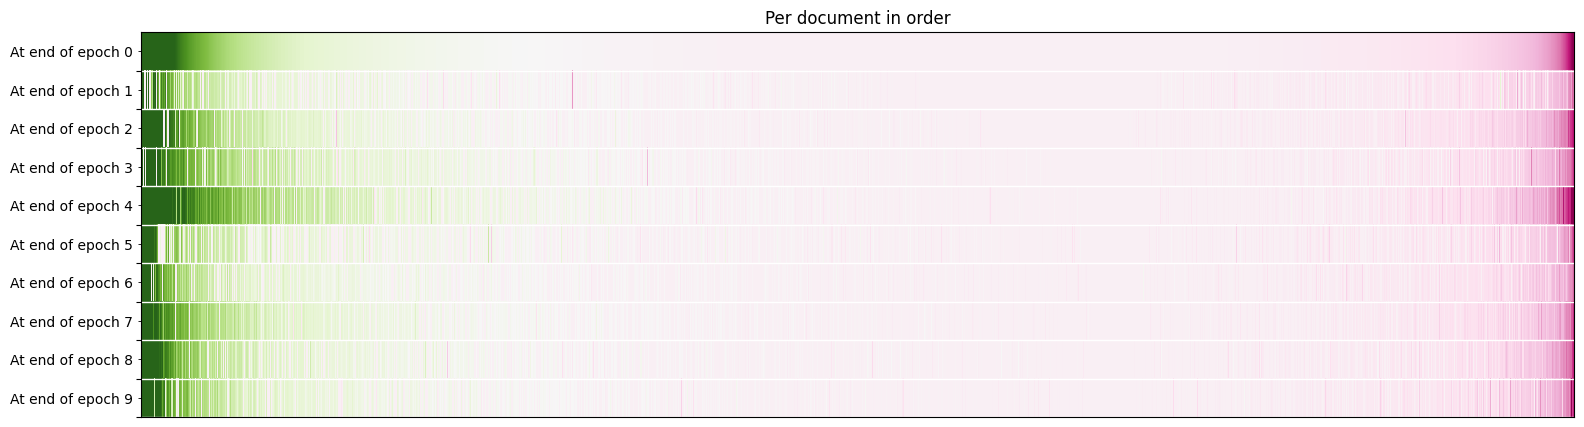

In [30]:
lognorm_order = get_order_full(reweight_df(df, influence_cols, lognorm_filter(len(influence_cols), s=1, loc=0, scale=0.5)))
plotting.plot_per_document_in_order(df, lognorm_order)
torch.save(lognorm_order, "./lognorm.pt")
api.upload_file(
        path_or_fileobj="./lognorm.pt",
        path_in_repo="lognorm.pt",
        repo_id=dataset_name,
        repo_type="dataset"
    )
os.remove("./lognorm.pt")

No files have been modified since last commit. Skipping to prevent empty commit.


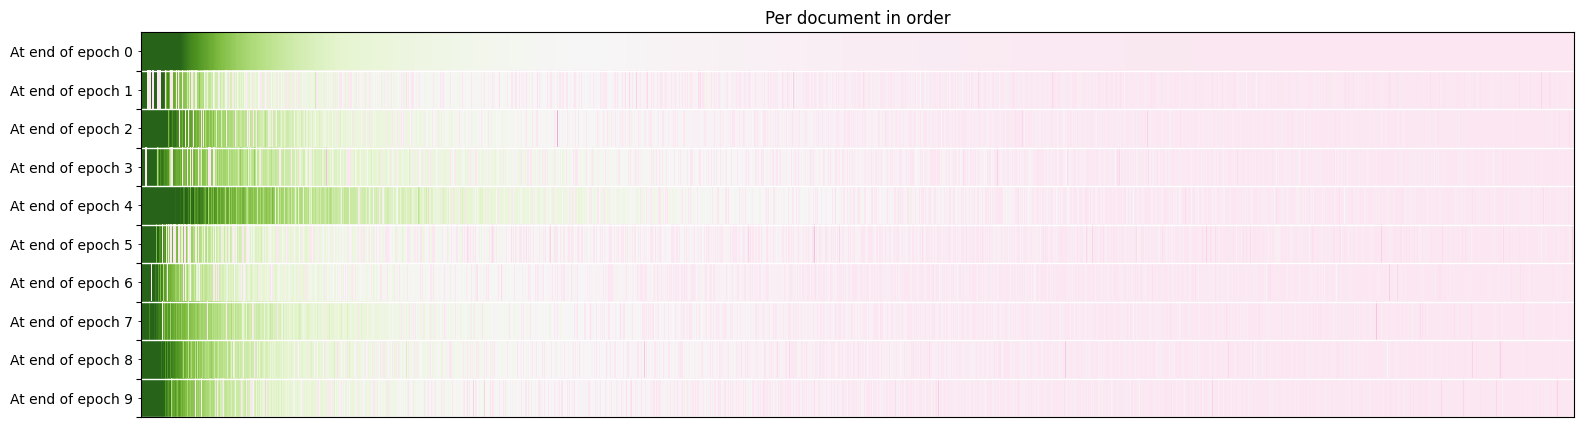

In [31]:
lognorm_order_top_50_pct = get_order_top_n_pct(50,reweight_df(df, influence_cols, lognorm_filter(len(influence_cols), s=1, loc=0, scale=0.5)))
plotting.plot_per_document_in_order(df, lognorm_order_top_50_pct)
torch.save(lognorm_order_top_50_pct, "./lognorm_top_50_pct.pt")
api.upload_file(
        path_or_fileobj="./lognorm_top_50_pct.pt",
        path_in_repo="lognorm_top_50_pct.pt",
        repo_id=dataset_name,
        repo_type="dataset"
    )
os.remove("./lognorm_top_50_pct.pt")

No files have been modified since last commit. Skipping to prevent empty commit.


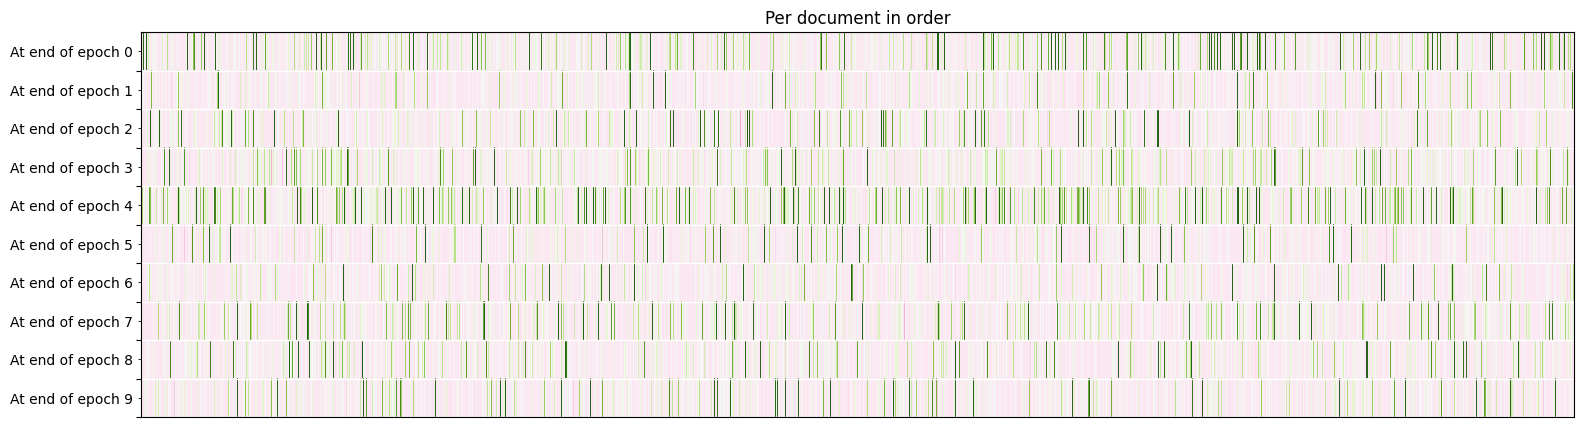

In [32]:
torch.manual_seed(42)
lognorm_order_top_50_pct_shuffled= torch.stack([row[torch.randperm(row.shape[0])] for row in lognorm_order_top_50_pct])
plotting.plot_per_document_in_order(df, lognorm_order_top_50_pct_shuffled)
torch.save(lognorm_order_top_50_pct_shuffled, "./lognorm_top_50_pct_shuffled.pt")
api.upload_file(
        path_or_fileobj="./lognorm_top_50_pct_shuffled.pt",
        path_in_repo="lognorm_top_50_pct_shuffled.pt",
        repo_id=dataset_name,
        repo_type="dataset"
    )
os.remove("./lognorm_top_50_pct_shuffled.pt")

No files have been modified since last commit. Skipping to prevent empty commit.


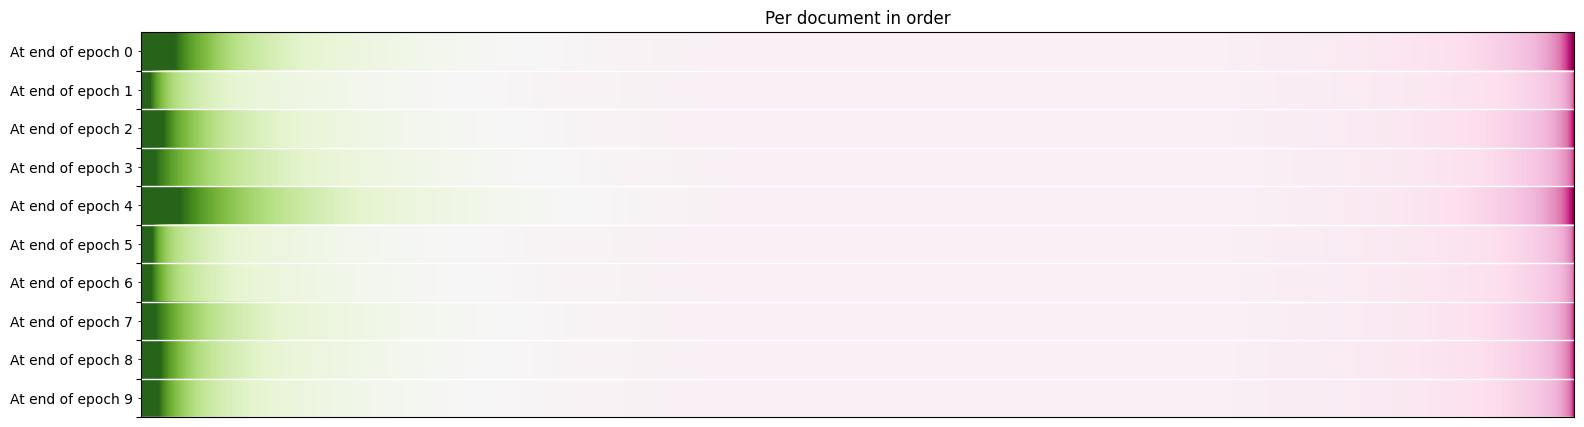

In [33]:
dirac_order = get_order_full(reweight_df(df, influence_cols, dirac_filter(len(influence_cols))))
plotting.plot_per_document_in_order(df, dirac_order)
torch.save(dirac_order, "./dirac.pt")
api.upload_file(
        path_or_fileobj="./dirac.pt",
        path_in_repo="dirac.pt",
        repo_id=dataset_name,
        repo_type="dataset"
    )
os.remove("./dirac.pt")

No files have been modified since last commit. Skipping to prevent empty commit.


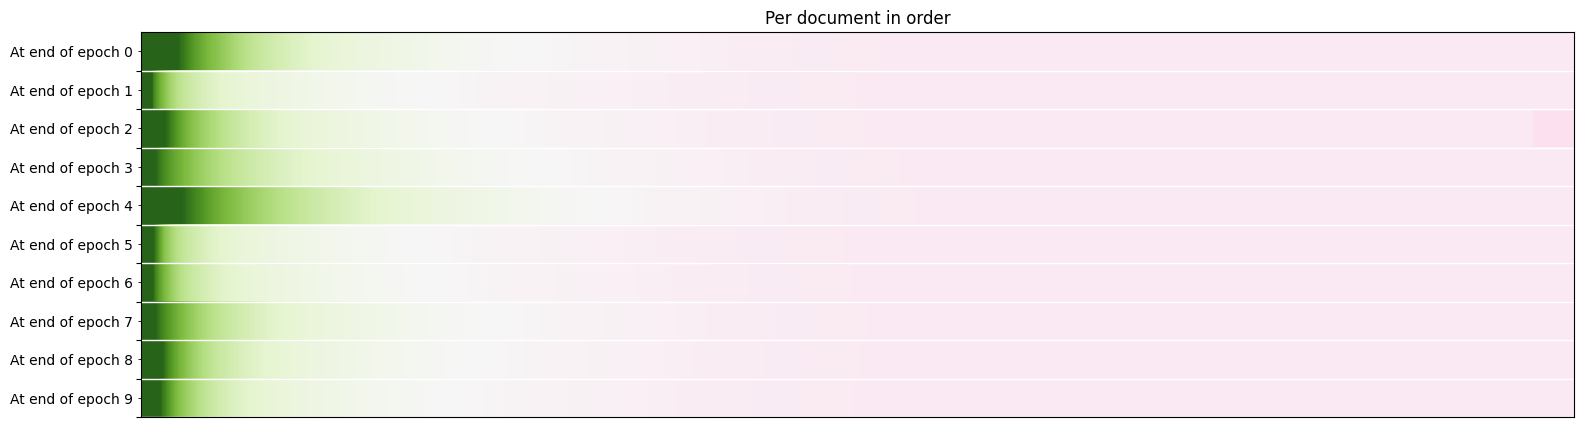

In [34]:
positive_only_order = get_order_positive_only(reweight_df(df, influence_cols, dirac_filter(len(influence_cols))))
plotting.plot_per_document_in_order(df, positive_only_order)
torch.save(positive_only_order, "./dirac_positive_only.pt")
api.upload_file(
        path_or_fileobj="./dirac_positive_only.pt",
        path_in_repo="dirac_positive_only.pt",
        repo_id=dataset_name,
        repo_type="dataset"
    )
os.remove("./dirac_positive_only.pt")

[tensor([356616,   4583,  92739,  ..., 136649, 245227, 261162]),
 tensor([646517, 260211, 540512,  ..., 607686, 624157, 255482]),
 tensor([750242,  29795, 549461,  ..., 331071,  39209, 844958]),
 tensor([133078, 667964,  79720,  ..., 575649, 599498, 839898]),
 tensor([ 90884, 580304, 682316,  ..., 422854, 868051, 505204]),
 tensor([784696, 758727, 372684,  ..., 932427, 391996, 470076]),
 tensor([963786, 682467, 768140,  ..., 693970, 772417, 233651]),
 tensor([974904, 379854, 477789,  ..., 580889, 868452, 667015]),
 tensor([679949,  75014, 969465,  ..., 406136, 734897, 678018]),
 tensor([955858, 838168, 879943,  ..., 806434, 299816, 131318])]

influential_examples_early.pt:   0%|          | 0.00/85.6M [00:00<?, ?B/s]

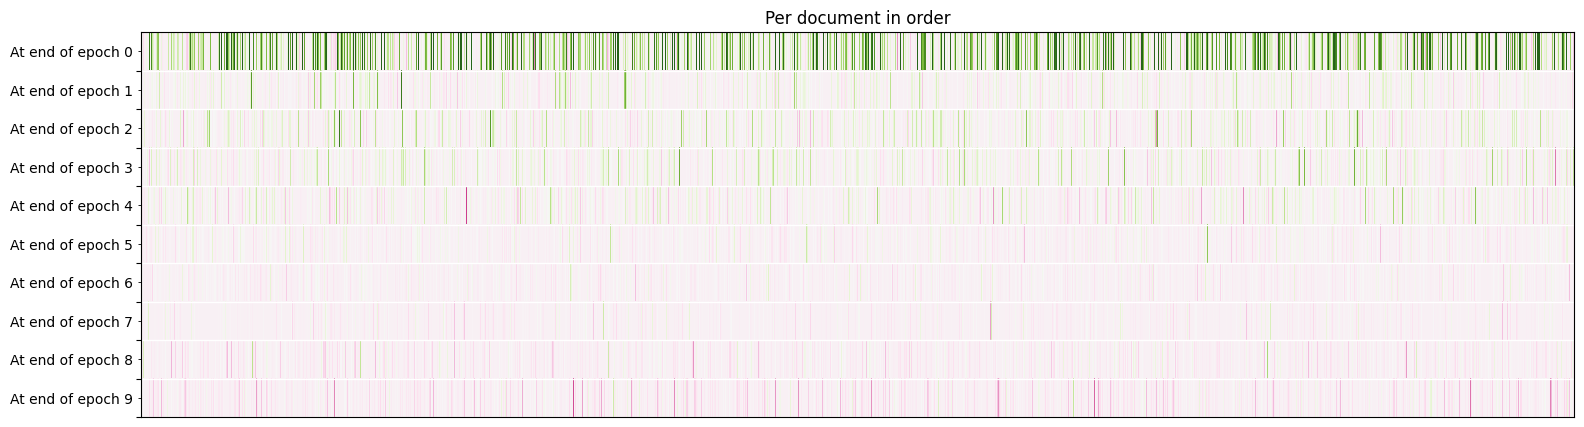

In [137]:
epochs = torch.tensor_split(torch.tensor(df.sort_values(by="total", ascending=False)["total"].index.to_numpy()), len(influence_cols))
epochs = [epoch.repeat(10) for epoch in epochs]
influential_examples_early_order = [epoch[torch.randperm(epoch.shape[0])] for epoch in epochs]
plotting.plot_per_document_in_order(df, influential_examples_early_order)
torch.save(influential_examples_early_order, "./influential_examples_early.pt")
api.upload_file(
        path_or_fileobj="./influential_examples_early.pt",
        path_in_repo="influential_examples_early.pt",
        repo_id=dataset_name,
        repo_type="dataset"
    )
os.remove("./influential_examples_early.pt")

In [136]:
influential_examples_early_order[0].shape

torch.Size([107033])

influential_examples_first_half.pt:   0%|          | 0.00/85.6M [00:00<?, ?B/s]

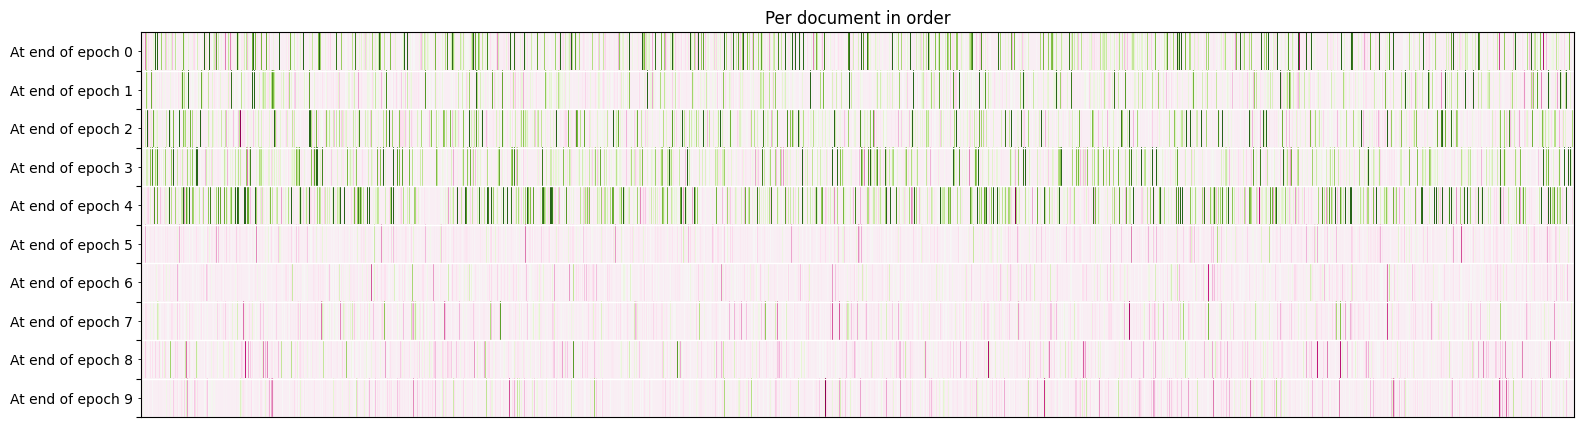

In [89]:
halfs = torch.tensor_split(torch.tensor(df.sort_values(by="total", ascending=False)["total"].index.to_numpy()), 2)
halfs = [half.repeat(10) for half in halfs]
influential_examples_first_half_order = list(torch.tensor_split(torch.cat([half[torch.randperm(len(half))] for half in halfs]), len(influence_cols)))
plotting.plot_per_document_in_order(df, influential_examples_first_half_order)
torch.save(influential_examples_first_half_order, "./influential_examples_first_half.pt")
api.upload_file(
        path_or_fileobj="./influential_examples_first_half.pt",
        path_in_repo="influential_examples_first_half.pt",
        repo_id=dataset_name,
        repo_type="dataset"
    )
os.remove("./influential_examples_first_half.pt")

influential_examples_first_third.pt:   0%|          | 0.00/85.6M [00:00<?, ?B/s]

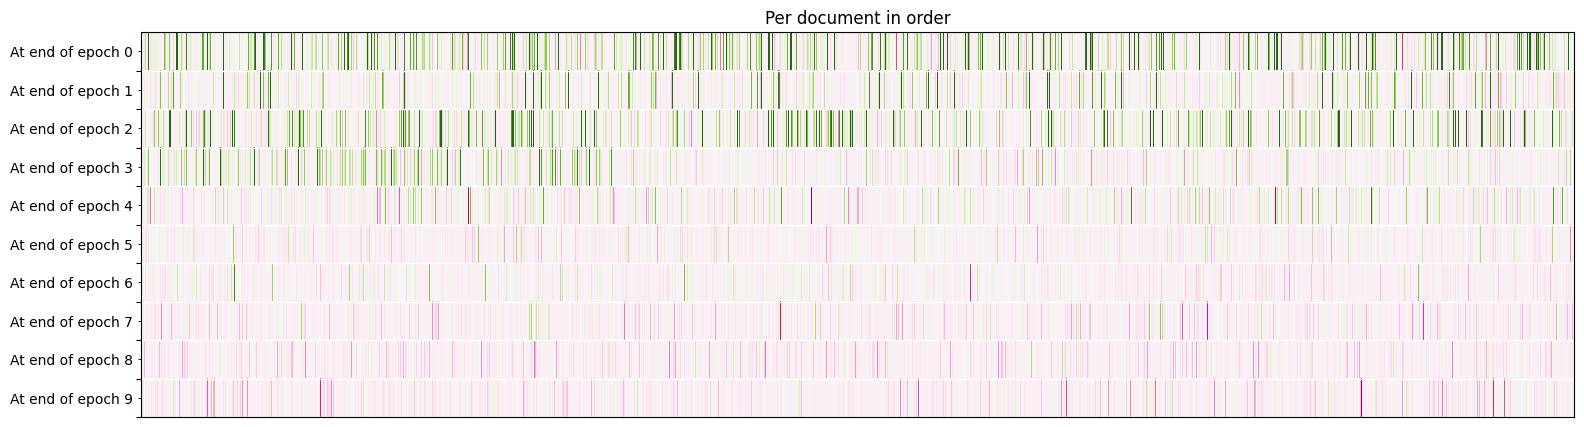

In [93]:
thirds = torch.tensor_split(torch.tensor(df.sort_values(by="total", ascending=False)["total"].index.to_numpy()), 3)
thirds = [third.repeat(10) for third in thirds]
influential_examples_first_third_order = list(torch.tensor_split(torch.cat([third[torch.randperm(len(third))] for third in thirds]), len(influence_cols)))
plotting.plot_per_document_in_order(df, influential_examples_first_third_order)
torch.save(influential_examples_first_third_order, "./influential_examples_first_third.pt")
api.upload_file(
        path_or_fileobj="./influential_examples_first_third.pt",
        path_in_repo="influential_examples_first_third.pt",
        repo_id=dataset_name,
        repo_type="dataset"
    )
os.remove("./influential_examples_first_third.pt")

influential_examples_sandwich.pt:   0%|          | 0.00/85.6M [00:00<?, ?B/s]

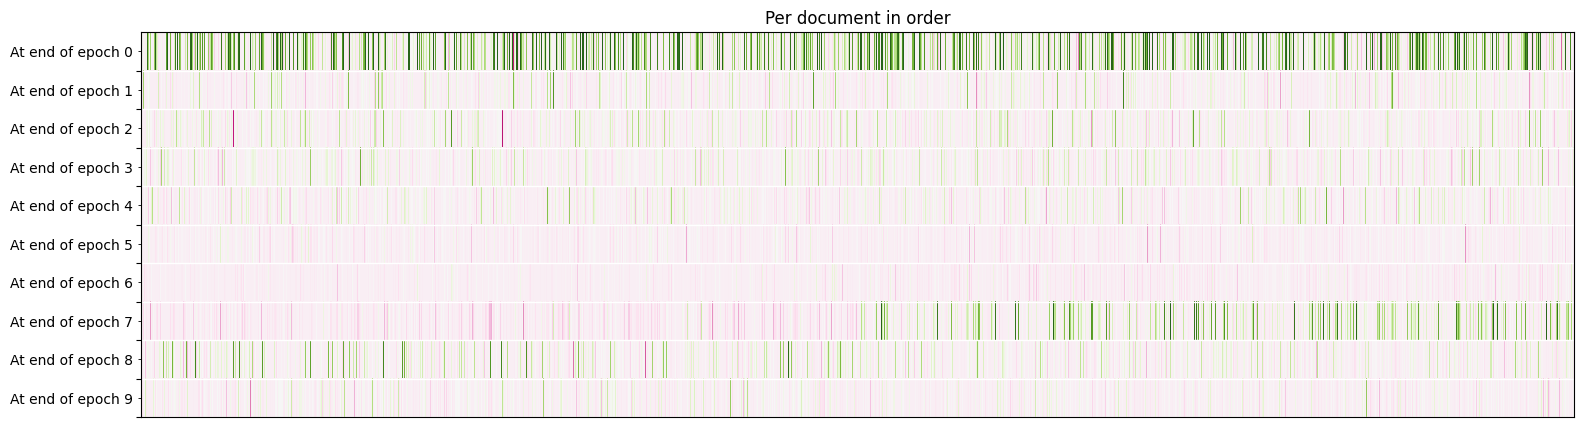

In [134]:
chunks = torch.tensor_split(torch.tensor(df.sort_values(by="total", ascending=False)["total"].index.to_numpy()), len(influence_cols))
beneficial_chunks = chunks[0:len(chunks)//2]
harmful_chunks = chunks[len(chunks)//2:]
beneficial_chunks_start = [beneficial_chunk.repeat(10) for beneficial_chunk in beneficial_chunks]
harmful_chunks = [harmful_chunk.repeat(5) for harmful_chunk in harmful_chunks]
beneficial_chunks_end = [beneficial_chunk.repeat(5) for beneficial_chunk in beneficial_chunks]
influential_examples_sandwich = list(torch.tensor_split(torch.cat([chunk[torch.randperm(len(chunk))] for chunk in beneficial_chunks_start + harmful_chunks + beneficial_chunks_end]), len(influence_cols)))
plotting.plot_per_document_in_order(df, influential_examples_sandwich)
torch.save(influential_examples_sandwich, "./influential_examples_sandwich.pt")
api.upload_file(
        path_or_fileobj="./influential_examples_sandwich.pt",
        path_in_repo="influential_examples_sandwich.pt",
        repo_id=dataset_name,
        repo_type="dataset"
    )
os.remove("./influential_examples_sandwich.pt")

In [130]:
torch.cat(influential_examples_sandwich).shape[0] - torch.cat(influential_examples_first_third_order).shape[0]

5

In [123]:
torch.cat(influential_examples_first_third_order).shape

torch.Size([10703210])

In [17]:
lognorm_order_top_50_pct

tensor([[ 10044, 288651, 283387,  ...,  31261,  31259,  31258],
        [281309, 286753, 287792,  ..., 711022, 910714, 456063],
        [ 89670, 208254, 281807,  ..., 435036, 834292, 549646],
        ...,
        [  6790, 454882, 632466,  ..., 187416, 674223, 755866],
        [245711, 242424, 242330,  ..., 290297, 298083, 290468],
        [161447, 161282, 162475,  ..., 870345, 208644, 537898]])